In [29]:
## imports 
# astro
from    astropy.wcs             import WCS
from    astropy.io              import fits
import  astropy.units           as u
from    astropy.nddata          import Cutout2D
from    astropy.coordinates     import SkyCoord
from    astropy.visualization   import (MinMaxInterval, PercentileInterval, ZScaleInterval, SqrtStretch, AsinhStretch, LogStretch, ImageNormalize)
# data 
import  numpy   as np
import  pandas  as pd
# plots
import  matplotlib.pyplot as plt
# file interpretation
import ast

## file paths 
path_catalogs = 'D:\\AstroCatalogs\\AGNerds'
path_cutouts = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\AGNerds\\AGNerds\\JWST_AGN_proj2\\Cutouts_duplicates'

# Read Files

In [30]:
# read file to get agn info
with open('tphotCoord_egs_duplicate_galaxies.txt') as file:
    galaxyCoordinants = ast.literal_eval( file.read() ) # converts str into dict 

print(galaxyCoordinants)


{(215.061708, 52.900944): [(215.061722, 52.900933, 'miri6'), (215.061896, 52.900765, 'miri6')], (215.044522, 52.894596): [(215.044535, 52.894589, 'miri6'), (215.044768, 52.894784, 'miri6')], (215.027832, 52.894548): [(215.027718, 52.894445, 'miri6'), (215.027837, 52.894547, 'miri6')], (215.033691, 52.909238): [(215.033689, 52.909234, 'miri6'), (215.033922, 52.909357, 'miri6')], (215.037311, 52.913392): [(215.03731, 52.913383, 'miri6'), (215.037553, 52.913339, 'miri6')], (215.016974, 52.901142): [(215.01698, 52.901149, 'miri6'), (215.017125, 52.901013, 'miri6')], (215.021841, 52.905244): [(215.021603, 52.9052, 'miri6'), (215.021839, 52.905239, 'miri6')], (215.032796, 52.915581): [(215.032782, 52.915564, 'miri6'), (215.033068, 52.915457, 'miri6')], (215.025932, 52.919903): [(215.025918, 52.919893, 'miri6'), (215.026152, 52.920017, 'miri6')], (215.172194, 53.03765): [(215.17185, 53.037536, 'miri1'), (215.172196, 53.037648, 'miri1')], (215.001349, 52.918369): [(215.001375, 52.918359, 'miri

In [31]:
# build dictionary of data, header, and wcs for a given fits file
def GetData(fitsFile, egs=False):
    f = fits.open(fitsFile)
    if(egs):
        wcs = WCS(f[0].header, relax=True)
    else: 
        wcs = WCS(f[1].header)
    # fill dictionary with data 
    dataDict = {
        'data'      : fits.getdata(fitsFile),
        'header'    : fits.getheader(fitsFile),
        'wcs'       : wcs
    }
    f.close()
    return(dataDict)

In [42]:
# read CEERS MIRI image data
miri = {
    'miri1' : {
        'f1000w' : GetData(path_catalogs+'\\ceers_miri1_f1000w_i2d.fits'),
        'f1280w' : GetData(path_catalogs+'\\ceers_miri1_f1280w_i2d.fits'),
        'f770w'  : GetData(path_catalogs+'\\ceers_miri1_f770w_i2d.fits')
    },
    'miri2' : {
        'f1000w' : GetData(path_catalogs+'\\ceers_miri2_f1000w_i2d.fits'),
        'f1280w' : GetData(path_catalogs+'\\ceers_miri2_f1280w_i2d.fits'),
        'f770w'  : GetData(path_catalogs+'\\ceers_miri2_f770w_i2d.fits')
    },
    'miri3' :{
        'f770w'  : GetData(path_catalogs+'\\ceers_miri3_f770w_i2d.fits')
    },
    'miri6' : {
        'f770w'  : GetData(path_catalogs+'\\ceers_miri6_f770w_i2d.fits')
    }
}
print('MIRI READ')
# read EGS data 
egs = {
    'f160w' : GetData(path_catalogs+'\\egs_all_wfc3_ir_f160w_030mas_v1.9_drz.fits', egs=True)
}
print('EGS READ')

Set DATE-AVG to '2022-06-21T19:01:47.926' from MJD-AVG.
Set DATE-END to '2022-06-21T19:17:17.099' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.743944 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725242515.981 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-21T19:37:34.014' from MJD-AVG.
Set DATE-END to '2022-06-21T19:52:51.177' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.748835 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725268421.305 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-21T18:25:23.072' from MJD-AVG.
Set DATE-END to '2022-06-21T18:40:42.862' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.739047 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725216509.255 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-21T23:48:57.498' from MJD-AVG.
Set DATE-END to '2022-06-22T00:04:15.579' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.782898 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725446993.656 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

MIRI READ


EGS READ


# Functions for Image Cutouts

In [33]:
## use this to look at whole image, not just cutout # TODO this 
# ax.imshow(data, origin='lower', cmap='gray')

In [34]:
def GetCutout(
    coord,  # center sky coordinate
    wcs,    # World Coordinate System
    data,   # image data
    dl=50   # cutout size 
):
    # get position on sky 
    x, y = wcs.world_to_pixel(coord)
    # make cutout 
    cutout = Cutout2D(data, position=(x,y), size=(dl,dl), wcs=wcs, mode='partial')
    return(cutout)

In [35]:
def PlotCutout(
    ax,
    cutout,
    center, # dl/2
    title,  # title 
    marks=[],   # add markers to these coordinantes
    useNorm=None,
    showGrid=False
) : 
    if(showGrid):
        # grid lines
        ax.grid(True, color='r', linestyle='--', linewidth=0.5)
    else:
        # hide ticks
        ax.set_xticks([])
        ax.set_yticks([])
    # hide axis lables
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')

    if(marks):
        for i,coord in enumerate(marks):
            # determine color 
            if(i==0):   c='green'
            else:       c='red'
            # plot mark
            ax.plot_coord(coord, "x", color=c)
    else:
        # circle center coord 
        circle = plt.Circle((center,center), 10, fc=(0,0,0,0), ec="red")
        ax.add_patch(circle)

    # set title
    ax.set_title(title,fontsize=14)
    
    # plot image
    if(useNorm == None) : 
        ax.imshow(cutout.data, origin='lower', cmap='gray')
    else:
        norm1 = ImageNormalize(cutout.data, interval=PercentileInterval(useNorm), stretch=AsinhStretch())
        ax.imshow(cutout.data, origin='lower', cmap='gray', norm=norm1)

In [36]:
def MakePlotOfSrc_OneBand(
    coord,  # SkyCoord of RA and Dec
    wcs,    # World Coordinate System
    data,   # image data
    band,   # title of subplot 
    title,  # plot title
    marks=[],   # add markers to these coordinantes.
    useNorm=None,   # normalization percent interval
    showGrid=False,
    dl=50,  # cutout size  
    fileName=''     # name and path of file to save to
):
    # image cutout  
    cutout = GetCutout(
        coord=coord,  # center sky coordinate
        wcs=wcs,    # World Coordinate System
        data=data,   # image data
        dl=dl   # cutout size 
    )
    # make figure 
    fig = plt.figure(figsize=(4,4.25), facecolor='white')
    if(showGrid):
        ax = fig.add_subplot(111, projection=cutout.wcs)
        fig.supxlabel('RA')
        fig.supylabel('Dec')
    else:
        ax = fig.add_subplot(111, projection=cutout.wcs)
        
    # plot image cutout on axis 
    PlotCutout(
        ax=ax,
        cutout=cutout,
        center=dl/2.0, 
        title=band,
        marks=marks,
        useNorm=useNorm,
        showGrid=showGrid
    )
   
    # labels
    fig.suptitle(title, fontsize=16)

    # save 
    if(fileName):
        plt.savefig(    
            fileName,
            bbox_inches ="tight",
            pad_inches=0.05,
            facecolor='w',
            edgecolor='w'
        )

# Plot Single Object

In [37]:
def TupleToCoord(tup):
    # tup : tuple where 0 is ra and 1 is dec in degrees 
    return SkyCoord(tup[0]*u.degree, tup[1]*u.degree)

In [38]:
def MarksFromDict(keyCoord,valCoords) :
    # first index is from key 
    marks = [TupleToCoord(keyCoord)]
    # add other coordinants to end of list 
    for c in valCoords : 
        marks.append(TupleToCoord(c))
    # return coordinate list
    return marks

Source == (214.973248, 52.90764) : [(214.973269, 52.907639, 'miri3'), (214.973546, 52.907664, 'miri3')]


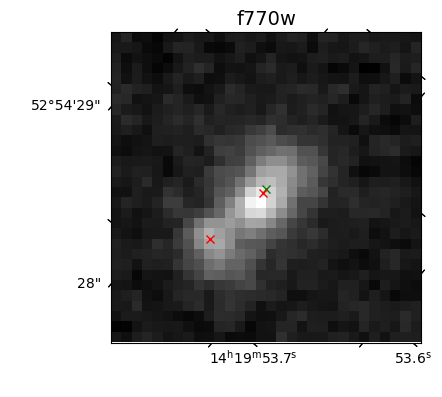

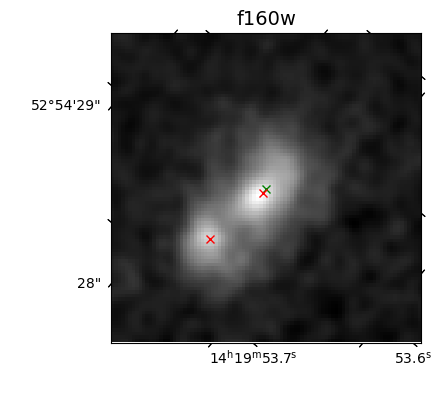

In [47]:
# dictionary format : 
#   key: tuple(ra,dec) for egs
#   value: list[tuple(ra,dec,field),...] for tphot 

# example source 
i=23
key,val = list(galaxyCoordinants.items())[i]
print('Source ==', key, ':', val)
# extract info from dict 
field_i = val[0][2] # gets miri field of first object --> [0] access first entry in list, [2] gets the field string
marks_i = MarksFromDict(key,val)

# plot tphot 
band = 'f770w'
MakePlotOfSrc_OneBand(
    coord = marks_i[0],
    wcs   = miri[field_i][band]['wcs'],    # World Coordinate System
    data  = miri[field_i][band]['data'],   # image data
    band  = band,   # title of subplot 
    title = '',  # plot title
    marks = marks_i,   # add markers to these coordinantes. format [(RA1,DEC1),(RA2,DEC2),...]
    useNorm=None,   # normalization percent interval
    showGrid=False,
    dl=30,  # cutout size  
    fileName=''     # name and path of file to save to
)

# plot egs
band = 'f160w'
MakePlotOfSrc_OneBand(
    coord = marks_i[0],
    wcs   = egs[band]['wcs'],    # World Coordinate System
    data  = egs[band]['data'],   # image data
    band  = band,   # title of subplot 
    title = '',  # plot title
    marks = marks_i,   # add markers to these coordinantes. format [(RA1,DEC1),(RA2,DEC2),...]
    useNorm=None,   # normalization percent interval
    showGrid=False,
    dl=90,  # cutout size  
    fileName=''     # name and path of file to save to
)

In [40]:
# TODO plot jwst and hst side by side, same frame same marks, change color of marks and add legend (egs blue, jwst red). 
# for jwst: stick with 770, look at 1000 if nothing in 770. for hst, stick with f160. 